In [1]:
# importing literature
import numpy as np

from pandas.tseries import *
from pandas_datareader.data import DataReader
from pandas_datareader import data
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

import cvxopt as opt
from cvxopt import blas, solvers
import scipy.optimize as sco
import seaborn as sns

C:\Users\Dell\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# all data are in the first differeance 
data = pd.read_excel('RS_data.xlsx')
data.set_index(data['assets'], inplace=True)
data.set_index('assets', inplace=True)
mean_returns = data.values

# covariance matrix
cov_matrix = pd.read_excel('RS_data2.xlsx')
assets = ["Gold return", "Oil retur", "US bond yield" ,"S&P", "JP bond yield", "Nikkei", "jpy/usd return" ,"GR 10-Y Bond Yield", " DAX",  " eur/usd", "Shanghai Composite" , "China 3-Year Bond Yield"]

In [14]:
print mean_returns

[[ 0.01062361  0.00743106 -0.00422779  0.00897748  0.00426562 -0.02438563
   0.00293997 -0.03289858  0.01458942  0.00488072 -0.00082884  0.0060012 ]]


In [16]:
mean_returns.dtype

dtype('float64')

In [32]:
len(assets)

12

In [3]:
#number of runs of random portfolio weights
num_portfolios = 1000000

risk_free_rate = 0.0146

In [49]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) 
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in xrange(num_portfolios):
        weights = np.random.random(12)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [5]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,3)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,3)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    
    print "-"*80
    print "Maximum Sharpe Ratio Portfolio Allocation\n"
    print "Return:", round(rp,3)
    print "Volatility:", round(sdp,3)
    print "\n"
    print max_sharpe_allocation
    print "-"*80
    print "Minimum Volatility Portfolio Allocation\n"
    print "Return:", round(rp_min,3)
    print "Volatility:", round(sdp_min,3)
    print "\n"
    print min_vol_allocation
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='b',s=500, label='Minimum volatility')
    plt.title('Portfolio Optimization and Efficient Frontier')
    plt.xlabel('volatility')
    plt.ylabel('returns')
    plt.legend(labelspacing=0.8)
    plt.savefig('3.png', dpi=199)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Return: 0.005
Volatility: 0.158


            Gold return  Oil return  US bond yield    S&P  JP bond yield  \
allocation        1.494      20.184           5.44  9.992         33.921   

            Nikkei  jpy/usd return  GR 10-Y Bond Yield    DAX  eur/usd  \
allocation   0.576           1.519               0.396  5.446    9.506   

            Shanghai Composite  China 3-Year Bond Yield   
allocation               2.405                      9.12  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Return: 0.003
Volatility: 0.01


            Gold return  Oil return  US bond yield     S&P  JP bond yield  \
allocation       19.118       1.152          8.719  11.759          0.816   

            Nikkei  jpy/usd return  GR 10-Y Bond Yield    DAX  eur/usd  \
allocation    9.32          20.947    

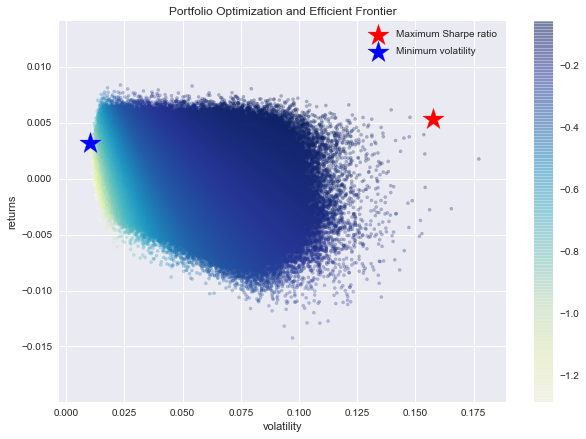

In [6]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

#Efficient Frontier

In [33]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(assets)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-1.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [69]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(assets)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-1.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [67]:
max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)

     fun: -0.7456934506951794
     jac: array([-0.07843696, -0.07858521, -0.07920936, -0.07848946, -0.07865804,
        0.18893337, -0.07836739, -0.08387937, -0.07858659, -0.07865104,
       -0.07824653, -0.07865334])
 message: 'Optimization terminated successfully.'
    nfev: 427
     nit: 30
    njev: 30
  status: 0
 success: True
       x: array([  6.35678865e-01,  -1.32500920e-01,  -5.63426121e-02,
        -6.33250111e-02,   2.23959663e-04,  -1.00000000e+00,
         3.19683905e-01,  -1.63139936e-02,   7.35418401e-01,
         6.19951008e-01,  -1.85876165e-01,   1.43402564e-01])

In [70]:
min_variance(mean_returns, cov_matrix)

     fun: 0.006910951874471264
     jac: array([ 0.00683305,  0.00709156,  0.00655455,  0.00687386,  0.00719828,
        0.00745855,  0.00689136,  0.00674208,  0.00664975,  0.0070087 ,
        0.00671282,  0.00695983])
 message: 'Optimization terminated successfully.'
    nfev: 383
     nit: 27
    njev: 27
  status: 0
 success: True
       x: array([  1.66457382e-01,  -4.13819682e-03,   3.69520378e-02,
        -6.46144143e-03,  -1.38859861e-03,   5.05723087e-02,
         4.54447929e-01,   8.46531673e-05,   4.81551414e-02,
         2.25462256e-01,   1.22184141e-02,   1.76381154e-02])

In [74]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(assets)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((-1,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [77]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,3)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,3)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print "-"*80
    print "Maximum Sharpe Ratio Portfolio Allocation\n"
    print "Return:", round(rp,3)
    print "Volatility:", round(sdp,3)
    print "\n"
    print max_sharpe_allocation
    print "-"*80
    print "Minimum Volatility Portfolio Allocation\n"
    print "Return:", round(rp_min,3)
    print "Volatility:", round(sdp_min,3)
    print "\n"
    print min_vol_allocation
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='b',s=500, label='Minimum volatility')
    
    target = np.linspace(rp_min, 0.06, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('volatility')
    plt.ylabel('returns')
    plt.legend(labelspacing=0.8)
    plt.savefig('2.png', dpi=199)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Return: 0.046
Volatility: 0.042


            Gold return  Oil return  US bond yield    S&P  JP bond yield  \
allocation       63.568      -13.25         -5.634 -6.333          0.022   

            Nikkei  jpy/usd return  GR 10-Y Bond Yield     DAX  eur/usd  \
allocation  -100.0          31.968              -1.631  73.542   61.995   

            Shanghai Composite  China 3-Year Bond Yield   
allocation             -18.588                     14.34  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Return: 0.004
Volatility: 0.007


            Gold return  Oil return  US bond yield    S&P  JP bond yield  \
allocation       16.646      -0.414          3.695 -0.646         -0.139   

            Nikkei  jpy/usd return  GR 10-Y Bond Yield    DAX  eur/usd  \
allocation   5.057          45.445   

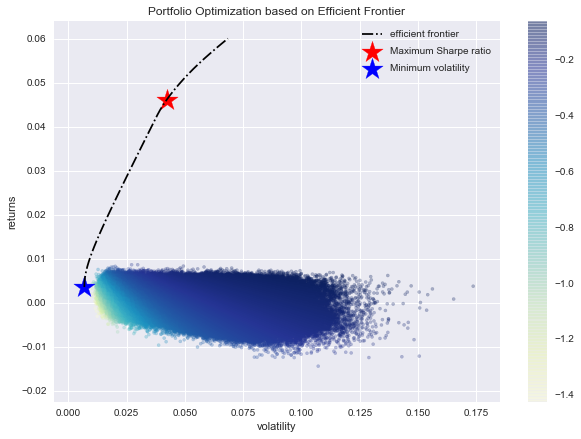

In [78]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)